# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.05490213376386954
 0.9095760800509126
 0.7927295459034683
 0.6942935431830888
 0.03744528289447213
 0.12848870749519825
 0.47252375082838904
 0.5734173952703241
 0.7043059747630693
 0.937589649387292
 ⋮
 0.440484273991685
 0.6822111614783225
 0.9997817233260247
 0.9010500638551409
 0.5931212025488246
 0.11817059204652292
 0.34429977796038846
 0.8236360191455382
 0.06618908913327182

In [3]:
sum(a)

5.000140154731147e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [4]:
@time sum(a)

  0.022929 seconds (1 allocation: 16 bytes)


5.000140154731147e6

In [5]:
@time sum(a)

  0.015236 seconds (1 allocation: 16 bytes)


5.000140154731147e6

In [6]:
@time sum(a)

  0.011935 seconds (1 allocation: 16 bytes)


5.000140154731147e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [7]:
using Pkg
Pkg.add("BenchmarkTools")

    Updating registry at `~/.julia/registries/General`


    Updating git-repo `https://github.com/JuliaRegistries/General.git`


   Resolving package versions...


  No Changes to `~/Desktop/OneDrive - usach.cl/PhD/Courses_Polymtl/OR Algorithms/Laboratory/Introduction-to-Julia/Project.toml`
  No Changes to `~/Desktop/OneDrive - usach.cl/PhD/Courses_Polymtl/OR Algorithms/Laboratory/Introduction-to-Julia/Manifest.toml`


In [8]:
using BenchmarkTools

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [9]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [10]:
c_sum(a)

5.000140154731255e6

In [11]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [12]:
c_sum(a) - sum(a)  

1.0803341865539551e-7

In [13]:
≈  # alias for the `isapprox` function

isapprox (generic function with 9 methods)

In [14]:
?isapprox

ErrorException: syntax: invalid identifier name "?"

We can now benchmark the C code directly from Julia:

In [15]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 246 samples with 1 evaluation.
 Range (min … max):  11.883 ms … 90.464 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     19.023 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   20.284 ms ±  6.950 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

        ▅▆▃▅█▄ ▁▅▂▆▄▃▁                                         
  ▃▃▁▃▄▄██████▆███████▆█▅▇▇▆▄▄▅▄▄▄▄▁▃▃▄▃▃▄▄▃▃▃▄▁▁▁▄▁▁▁▁▁▁▁▁▁▃ ▄
  11.9 ms         Histogram: frequency by time        38.7 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [16]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 11.882539 msec


In [17]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 11.8825

In [18]:
using Plots
gr()

Plots.GRBackend()

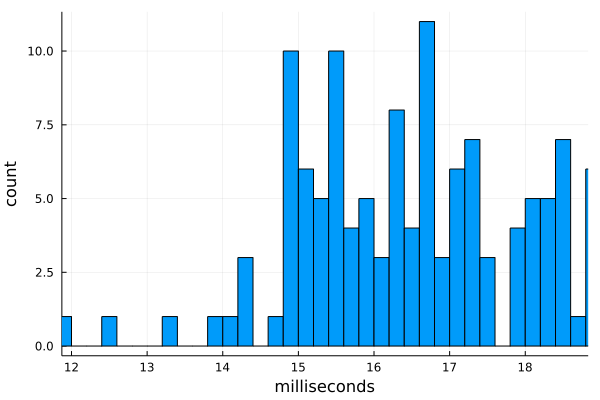

In [19]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [20]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [21]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 446 samples with 1 evaluation.
 Range (min … max):   6.282 ms … 39.302 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     10.438 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   11.189 ms ±  3.759 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

      ▃▃▄▆▅▆▇▇█▆▆▇▁▆▂▁                                         
  ▄▆▅███████████████████▆█▆▄▇▃▅▅▄▆▃▁▃▁▁▃▁▁▃▃▁▃▃▁▁▃▃▃▃▃▁▃▁▁▃▁▃ ▄
  6.28 ms         Histogram: frequency by time        24.5 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [22]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

6.281762

# 3. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [23]:
using Pkg; Pkg.add("PyCall")
using PyCall

   Resolving package versions...


  No Changes to `~/Desktop/OneDrive - usach.cl/PhD/Courses_Polymtl/OR Algorithms/Laboratory/Introduction-to-Julia/Project.toml`
  No Changes to `~/Desktop/OneDrive - usach.cl/PhD/Courses_Polymtl/OR Algorithms/Laboratory/Introduction-to-Julia/Manifest.toml`


In [24]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [26]:
pysum(a)

5.000140154731255e6

In [27]:
pysum(a) ≈ sum(a)

true

In [29]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 4 samples with 1 evaluation.
 Range (min … max):  1.514 s …   1.742 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.578 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.603 s ± 97.489 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █              ██                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.51 s         Histogram: frequency by time        1.74 s <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [30]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 11.8825
  "Python built-in" => 1513.53
  "C -ffast-math"   => 6.28176

# 4. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [31]:
using Pkg; Pkg.add("Conda")
using Conda

   Resolving package versions...


  No Changes to `~/Desktop/OneDrive - usach.cl/PhD/Courses_Polymtl/OR Algorithms/Laboratory/Introduction-to-Julia/Project.toml`
  No Changes to `~/Desktop/OneDrive - usach.cl/PhD/Courses_Polymtl/OR Algorithms/Laboratory/Introduction-to-Julia/Manifest.toml`


In [32]:
Conda.add("numpy")

┌ Info: Running `conda install -y numpy` in root environment
└ @ Conda /Users/luisrojo/.julia/packages/Conda/x2UxR/src/Conda.jl:127


done
Solving environment: ...working... 

done



# All requested packages already installed.

Retrieving notices: ...working... 

done


In [33]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 422 samples with 1 evaluation.
 Range (min … max):   5.912 ms … 42.416 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     11.251 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   11.822 ms ±  4.154 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▂▂    ▃▅▃▅▂█▃▄▄▄▃▃▁ ▁▂                                     
  ▅▆███▇█▆█████████████▆██▇▇▅▅▆▆▄▅▃▃▅▃▄▅▁▃▁▃▄▁▁▃▁▁▁▁▃▃▁▁▁▃▁▁▃ ▄
  5.91 ms         Histogram: frequency by time        26.5 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [34]:
numpy_sum(a)

5.000140154731145e6

In [35]:
numpy_sum(a) ≈ sum(a)

true

In [37]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"               => 11.8825
  "Python numpy"    => 5.91225
  "Python built-in" => 1513.53
  "C -ffast-math"   => 6.28176

# 5. Python, hand-written 

In [38]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x13c4fa8c0>

In [39]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 3 samples with 1 evaluation.
 Range (min … max):  1.950 s …    2.400 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.117 s               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.156 s ± 227.507 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                    █                                   █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.95 s         Histogram: frequency by time          2.4 s <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [40]:
sum_py(a)

5.000140154731255e6

In [41]:
sum_py(a) ≈ sum(a)

true

In [42]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"                   => 11.8825
  "Python numpy"        => 5.91225
  "Python hand-written" => 1949.73
  "Python built-in"     => 1513.53
  "C -ffast-math"       => 6.28176

# 6. Julia (built-in) 

## Written directly in Julia, not in C!

In [43]:
@which sum(a)

sum(a::AbstractArray; dims, kw...) in Base at reducedim.jl:994

In [44]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 387 samples with 1 evaluation.
 Range (min … max):   5.806 ms … 48.842 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     11.771 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   12.903 ms ±  5.580 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▂▃   ▄ ▁▃ ▃██▃▆▃▁▂▁ ▅                                        
  ██▇█▆████▇█████████▇█▇▇▆▆▅▄▄▇▄▃▄▆▄▄▄▁▃▄▄▁▃▃▁▃▃▃▄▁▁▃▃▁▁▁▃▃▁▃ ▄
  5.81 ms         Histogram: frequency by time        30.6 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [45]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "C"                   => 11.8825
  "Python numpy"        => 5.91225
  "Python hand-written" => 1949.73
  "Python built-in"     => 1513.53
  "Julia built-in"      => 5.80591
  "C -ffast-math"       => 6.28176

# 7. Julia (hand-written) 

In [46]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [47]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 254 samples with 1 evaluation.
 Range (min … max):  12.311 ms … 49.364 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     19.002 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   19.636 ms ±  4.313 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

              ▅▄█▁▂▆▄▃ ▁▄▅▃ ▂▂ ▂                               
  ▃▃▇▆▅▄▄▃▇▇▇▇████████████████▄█▇▅▇▄▄▃▄▄▅▆▄▄▆▆▄▄▃▅▃▃▄▁▁▃▁▁▁▁▄ ▄
  12.3 ms         Histogram: frequency by time        30.9 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [48]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 7 entries:
  "C"                   => 11.8825
  "Python numpy"        => 5.91225
  "Julia hand-written"  => 12.3112
  "Python hand-written" => 1949.73
  "Python built-in"     => 1513.53
  "Julia built-in"      => 5.80591
  "C -ffast-math"       => 6.28176

# 8. Julia (hand-written w. simd) 

In [49]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [50]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 427 samples with 1 evaluation.
 Range (min … max):   5.855 ms … 61.156 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     11.041 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   11.673 ms ±  4.864 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▂ ▂ ▂▃█▄▄▄▂▁▆█▄▄ ▂                                          
  ▆█▇█████████████████▆▆▅▅▄▆▄▄▄▃▄▃▂▃▂▂▁▂▄▁▂▂▂▁▂▁▂▁▁▁▂▂▁▁▁▂▁▁▂ ▄
  5.85 ms         Histogram: frequency by time        29.3 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [51]:
mysum_simd(a)

5.000140154731166e6

In [52]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 8 entries:
  "Julia hand-written simd" => 5.85497
  "C"                       => 11.8825
  "Python numpy"            => 5.91225
  "Julia hand-written"      => 12.3112
  "Python hand-written"     => 1949.73
  "Python built-in"         => 1513.53
  "Julia built-in"          => 5.80591
  "C -ffast-math"           => 6.28176

# Summary

In [53]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

Julia built-in..............5.8
Julia hand-written simd.....5.9
Python numpy................5.9
C -ffast-math...............6.3
C..........................11.9
Julia hand-written.........12.3
Python built-in..........1513.5
Python hand-written......1949.7
